In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import time
import os
import sys
from tqdm import tqdm_notebook, trange
import itertools
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

In [0]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [0]:
DIR_PATH = '/content/drive/My Drive/Colab Notebooks/Reuters'

Загружаем данные

In [6]:
%%time
from sklearn.datasets import fetch_rcv1
rcv1 = fetch_rcv1()

CPU times: user 4.28 s, sys: 432 ms, total: 4.71 s
Wall time: 4.77 s


### Подготовка данных

Выкинем класс, который встречался всего 5 раз

In [0]:
sum_classes = np.array(rcv1.target.sum(axis=0))[0]
rcv1.target = rcv1.target[:, sum_classes > 5]
rcv1.target_names = rcv1.target_names[sum_classes > 5]

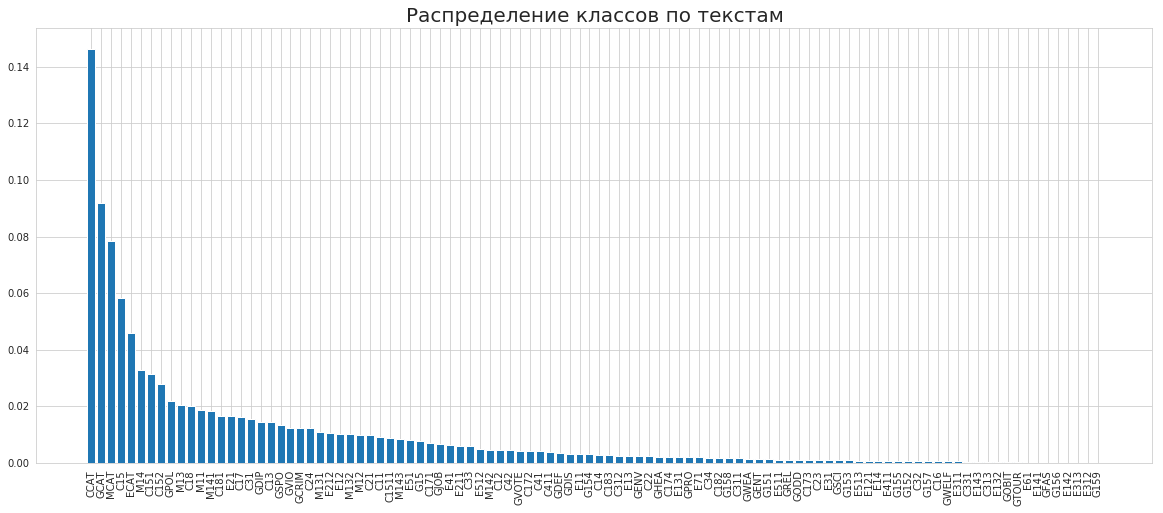

In [8]:
counts = rcv1.target.toarray().sum(axis=0)
names = rcv1.target_names[np.argsort(counts)[::-1]]
counts = np.sort(counts)[::-1]
plt.figure(figsize=(20, 8))
plt.bar(names, counts/counts.sum())
plt.title('Распределение классов по текстам', fontsize=20)
plt.xticks(rotation=90);

In [0]:
# tr_indexes, te_indexes = train_test_split(np.arange(rcv1.data.shape[0]), test_size=0.3, shuffle=True)
# np.save(os.path.join(DIR_PATH, 'reuters_train_indexes.npy'), tr_indexes)
# np.save(os.path.join(DIR_PATH, 'reuters_test_indexes.npy'), te_indexes)
tr_indexes = np.load(os.path.join(DIR_PATH, 'reuters_train_indexes.npy'))
te_indexes = np.load(os.path.join(DIR_PATH, 'reuters_test_indexes.npy'))

Посмотрим, сколько слов встречалось меньше 20 раз во всём корпусе и удалим эти слова

In [10]:
less_20 = (np.array(rcv1.data.sum(axis=0))[0] <= 20)
print('Количество слов, встретившихся меньше 20 раз во всём корпусе:', less_20.sum())
needed_features = np.arange(rcv1.data.sum(axis=0).shape[1])[~less_20]

Количество слов, встретившихся меньше 20 раз во всём корпусе: 29671


In [0]:
X_tr = rcv1.data[tr_indexes][:, needed_features]
y_tr = rcv1.target[tr_indexes]
X_te = rcv1.data[te_indexes][:, needed_features]
y_te = rcv1.target[te_indexes]

Посчитаем статистики для каждого столбца: средний tf_idf, стандартное отклонение tf_idf

In [12]:
nonzero_count = np.unique(np.nonzero(X_tr)[1], return_counts=True)[1]
mean_tf_idf = np.array(X_tr.sum(axis=0))[0]/nonzero_count
std_tf_idf = np.sqrt(np.array(X_tr.power(2).sum(axis=0))[0]/(nonzero_count + 1e-120) - (mean_tf_idf)**2)
std_tf_idf[np.isnan(std_tf_idf)] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


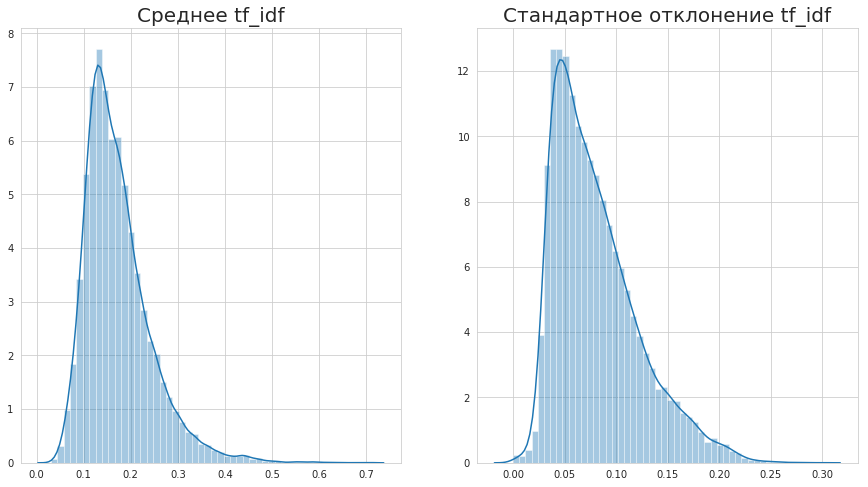

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
sns.distplot(mean_tf_idf, ax=ax[0])
sns.distplot(std_tf_idf, ax=ax[1]);
ax[0].set_title('Среднее tf_idf', fontsize=20);
ax[1].set_title('Стандартное отклонение tf_idf', fontsize=20);

Оставим столбцы с небольшим стандартным отклонением и большим значением tf-idf

In [14]:
needed_features = needed_features[(mean_tf_idf > 0.14) & (std_tf_idf < 0.1)]
needed_features.shape[0]

6341

In [0]:
X_tr = rcv1.data[tr_indexes][:, needed_features]
y_tr = rcv1.target[tr_indexes]
X_te = rcv1.data[te_indexes][:, needed_features]
y_te = rcv1.target[te_indexes]

### Построение моделей

Зафиксируем в качестве метрики f1 меру как композитную метрику точности и полноты.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

#### Классические

In [0]:
%%time
models_dict = {}
for i, name in tqdm_notebook(enumerate(rcv1.target_names)):
#     model = LGBMClassifier(subsample=0.05, colsample_bytree=1e-3)
    model = LogisticRegression(C=10)
    model.fit(X_tr, y_tr[:, i].toarray().ravel())
    models_dict[name] = model

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



CPU times: user 5min 39s, sys: 3.22 s, total: 5min 43s
Wall time: 5min 43s


In [0]:
# Сохраняем модели на диск
# joblib.dump(models_dict, open(os.path.join(DIR_PATH, 'logregs_dict.pkl'), mode='wb'))

In [0]:
# Загружаем модели с диска
# models_dict = joblib.load(open(os.path.join(DIR_PATH, 'logregs_dict.pkl'), mode='rb'))

In [39]:
y_pred = np.hstack([models_dict[name].predict_proba(X_te)[:, 1].reshape(-1, 1) for name in tqdm_notebook(rcv1.target_names)])

In [41]:
logreg_metric_by_class = {}
for i, class_name in tqdm_notebook(enumerate(rcv1.target_names)):
    if np.unique(y_te[:, i].toarray().ravel()).shape[0] > 1:
        logreg_metric_by_class[class_name] = f1_score(y_true=y_te[:, i].toarray().ravel(), y_pred=(y_pred[:, i] >= 0.5).astype(int))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


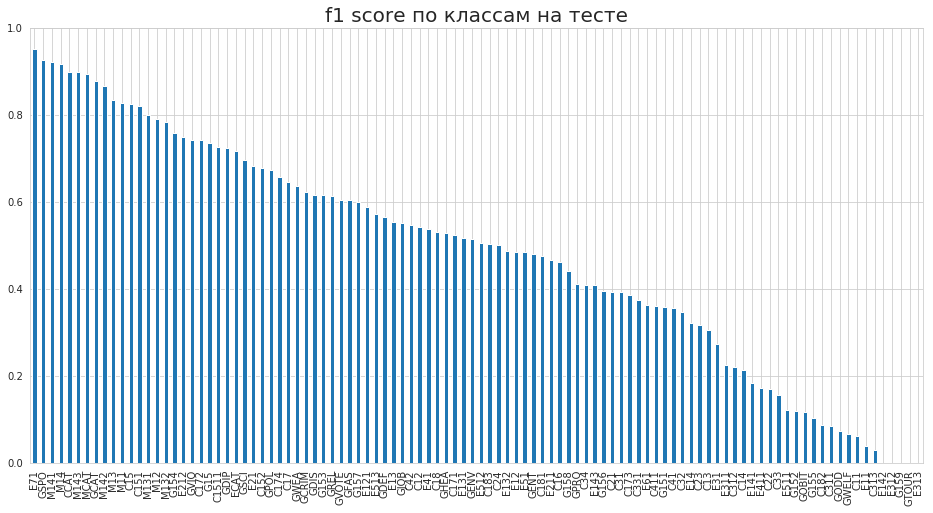

In [42]:
plt.figure(figsize=(16, 8))
pd.Series(metric_by_class).sort_values(ascending=False).plot(kind='bar');
plt.title('f1 score по классам на тесте', fontsize=20);

#### Нейросетки

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [0]:
BATCH_SIZE = 200
# sparse_train = scipy.sparse.hstack((X_tr, y_tr))
# sparse_test = scipy.sparse.hstack((X_tr, y_tr))
train_batch_indexes_list = np.split(np.random.permutation(X_tr.shape[0]), np.cumsum([BATCH_SIZE for i in 
                                                                                       range(int(np.floor(X_tr.shape[0])/BATCH_SIZE))]))
test_batch_indexes_list = np.split(np.random.permutation(X_te.shape[0]), np.cumsum([BATCH_SIZE for i in 
                                                                                       range(int(np.floor(X_te.shape[0])/BATCH_SIZE))]))
# train_loader = DataLoader(np.c_[X_tr.toarray(), y_tr.toarray()], batch_size=BATCH_SIZE, shuffle=True) # создаём генеритор батчей для теина и теста
# test_loader = DataLoader(np.c_[X_te.toarray(), y_te.toarray()], batch_size=BATCH_SIZE, shuffle=True)
INPUT_SIZE = X_tr.shape[1]
N_CLASSES = y_tr.shape[1]
LEN_TRAIN_BATCH = X_tr.shape[0]/BATCH_SIZE
LEN_TEST_BATCH = X_te.shape[0]/BATCH_SIZE

In [0]:
class FFNet(nn.Module):
    def __init__(self, linear1=(1200, 1300), linear2=(500, 600), linear3=(400, 300), linear4=(100, 200)):
        super(FFNet, self).__init__()
        self.linear1 = nn.Linear(linear1[0], linear1[1])
        self.linear2 = nn.Linear(linear2[0], linear2[1])
        self.linear3 = nn.Linear(linear3[0], linear3[1])
        self.linear4 = nn.Linear(linear4[0], linear4[1])
        self.dropout_input = nn.Dropout(p=0.2)
        self.dropout_innerlayer = nn.Dropout(p=0.5)
        self.batch_norm1 = nn.BatchNorm1d(linear1[1])
        self.batch_norm2 = nn.BatchNorm1d(linear2[1])
        self.batch_norm3 = nn.BatchNorm1d(linear3[1])
        
    def forward(self, x):
        out = F.relu(self.batch_norm1(self.linear1(self.dropout_input(x))))
        out = F.relu(self.batch_norm2(self.linear2(self.dropout_innerlayer(out))))
        out = F.relu(self.batch_norm3(self.linear3(self.dropout_innerlayer(out))))
        return self.linear4(self.dropout_innerlayer(out))

In [0]:
# Полносвзяная сетка
model = FFNet(linear1=(INPUT_SIZE, 3000), linear2=(3000, 2000), linear3=(2000, 500), linear4=(500, N_CLASSES))
model.load_state_dict(torch.load(os.path.join(DIR_PATH, 'epoch25')))
model.cuda()
criterion = nn.BCEWithLogitsLoss(reduction='mean')#, weight=torch.FloatTensor(classes_weights))
criterion.cuda()
opt = optim.Adam(model.parameters(), lr=1e-2)
reduce_plato = optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=0.01)
# scheduler = optim.lr_scheduler.ExponentialLR(opt, 0.6, last_epoch=-1)

In [58]:
EPOCHS = 100
DEVICE = 'cuda'
model.to(DEVICE)
criterion.to(DEVICE)
train_loss = []
test_loss = []
f1_train = []
f1_test = []
for i in range(1, EPOCHS+1):
    model.to(DEVICE)
    model.train()
    local_train_loss = 0
    st = time.perf_counter()
    train_batch_indexes_list = np.split(np.random.permutation(X_tr.shape[0]), np.cumsum([BATCH_SIZE for i in 
                                                                                       range(int(np.floor(X_tr.shape[0])/BATCH_SIZE))]))
    for batch_indexes in train_batch_indexes_list:
        opt.zero_grad()
        x = torch.FloatTensor(X_tr[batch_indexes].toarray()).to(DEVICE)
        y = torch.FloatTensor(y_tr[batch_indexes].toarray()).to(DEVICE)
        y_pred = model(x)
#         global_y_train_predictions = np.vstack((global_y_train_predictions, y_pred.cpu().detach().numpy()))
        loss = criterion(y_pred, y)
        local_train_loss += loss.item()/LEN_TRAIN_BATCH
        loss.backward()
        opt.step()
#     if i%10 == 0:
#         scheduler.step()
    train_loss.append(local_train_loss)
    
    with torch.no_grad():
        model.eval()
        local_test_loss = 0
#         global_y_test_predictions = np.zeros((0, N_CLASSES))
        test_batch_indexes_list = np.split(np.random.permutation(X_te.shape[0]), np.cumsum([BATCH_SIZE for i in 
                                                                                       range(int(np.floor(X_te.shape[0])/BATCH_SIZE))]))
        for batch_indexes in train_batch_indexes_list:
#             opt.zero_grad()
            x = torch.FloatTensor(X_tr[batch_indexes].toarray()).to(DEVICE)
            y = torch.FloatTensor(y_tr[batch_indexes].toarray()).to(DEVICE)
            y_pred = model(x)
#             global_y_test_predictions = np.vstack((global_y_test_predictions, y_pred.cpu().detach().numpy()))
            loss = criterion(y_pred, y)
            local_test_loss += loss.item()/LEN_TEST_BATCH
        test_loss.append(local_test_loss)
        reduce_plato.step(local_test_loss)
        
        
    torch.save(model.cpu().state_dict(), os.path.join(DIR_PATH, 'epoch{}'.format(i)))
                    
        
#     if (i+1)%5 == 0:
    print('Epoch:', i, 
          'Train loss: {:.4f}'.format(train_loss[-1]), 'Test loss: {:.4f}'.format(test_loss[-1]), 
          'Time: {:.2f}'.format(time.perf_counter() - st))

Epoch: 29 Train loss: 0.0422 Test loss: 0.0646 Time: 64.17
Epoch: 30 Train loss: 0.0419 Test loss: 0.0644 Time: 65.18
Epoch: 31 Train loss: 0.0418 Test loss: 0.0641 Time: 65.09
Epoch: 32 Train loss: 0.0417 Test loss: 0.0629 Time: 66.52
Epoch: 33 Train loss: 0.0415 Test loss: 0.0625 Time: 65.14
Epoch: 34 Train loss: 0.0414 Test loss: 0.0623 Time: 65.47
Epoch: 35 Train loss: 0.0413 Test loss: 0.0625 Time: 67.55
Epoch: 36 Train loss: 0.0411 Test loss: 0.0610 Time: 67.55
Epoch: 37 Train loss: 0.0410 Test loss: 0.0615 Time: 66.68
Epoch: 38 Train loss: 0.0409 Test loss: 0.0609 Time: 65.73
Epoch: 39 Train loss: 0.0407 Test loss: 0.0608 Time: 65.74
Epoch: 40 Train loss: 0.0407 Test loss: 0.0609 Time: 68.37
Epoch: 41 Train loss: 0.0406 Test loss: 0.0595 Time: 71.49
Epoch: 42 Train loss: 0.0405 Test loss: 0.0594 Time: 69.93
Epoch: 43 Train loss: 0.0403 Test loss: 0.0602 Time: 71.03
Epoch: 44 Train loss: 0.0403 Test loss: 0.0598 Time: 69.96
Epoch: 45 Train loss: 0.0402 Test loss: 0.0589 Time: 70.

KeyboardInterrupt: ignored

In [0]:
# k = 89
# for i in range(1, k):
#   if 'epoch{}'.format(i) in os.listdir(DIR_PATH):
#     os.remove(os.path.join(DIR_PATH, 'epoch{}'.format(i)))

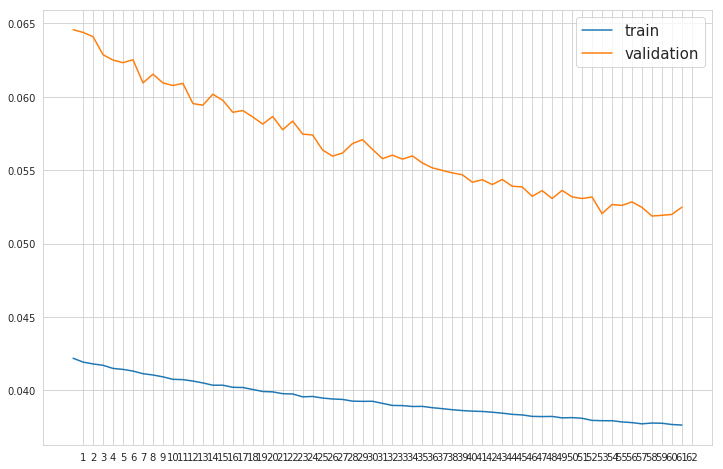

In [64]:
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='validation');
plt.xticks(np.arange(1, len(train_loss)+1), np.arange(1, len(train_loss)+1))
plt.legend(fontsize=15);

In [65]:
model.eval()
model.cpu()
k = 20000
y_pred = np.concatenate([(torch.sigmoid(model(torch.FloatTensor(X_te[k*i: k*(i+1)].toarray()))) > 0.5).detach().numpy().astype(int) for i in trange(y_te.shape[0]//k + 1)])
y_true = y_te.toarray()
nn_metric_by_class = {}
for i, class_name in tqdm_notebook(enumerate(rcv1.target_names)):
    if np.unique(y_te[:, i].toarray().ravel()).shape[0] > 1:
        nn_metric_by_class[class_name] = f1_score(y_true=y_te[:, i].toarray().ravel(), y_pred=y_pred[:, i])

100%|██████████| 13/13 [00:47<00:00,  2.78s/it]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [66]:
compare_metrics = []
for i, target in tqdm_notebook(enumerate(rcv1.target_names)):
  compare_metrics.append([target, nn_metric_by_class[target], logreg_metric_by_class[target]])
compare_metrics = np.array(compare_metrics)

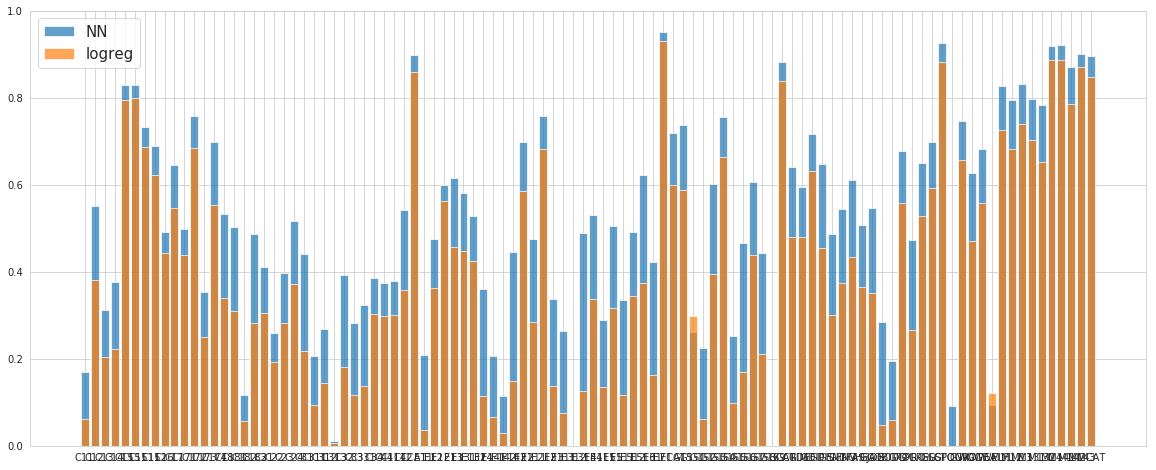

In [67]:
plt.figure(figsize=(20, 8))
plt.bar(compare_metrics[:, 0], compare_metrics[:, 1].astype(float), label='NN', alpha=0.7)
plt.bar(compare_metrics[:, 0], compare_metrics[:, 2].astype(float), label='logreg', alpha=0.7)
plt.legend(fontsize=15);

Нейросетка обогнала логрег почти по всех классам